# Two Layer Neural Network

run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [3]:
import torch
import os
import matplotlib.pyplot as plt
import statistics
import random
import time
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Implementing a Neural Network

the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

The outputs of the second fully-connected layer are the scores for each class

## Play with a toy data

The inputs to our network will be a batch of $N$ (`num_inputs`) $D$-dimensional vectors (`input_size`); the hidden layer will have $H$ hidden units (`hidden_size`), and we will predict classification scores for $C$ categories (`num_classes`). This means that the learnable weights and biases of the network will have the following shapes:

*   W1: First layer weights; has shape (D, H)
*   b1: First layer biases; has shape (H,)
*   W2: Second layer weights; has shape (H, C)
*   b2: Second layer biases; has shape (C,)

### Forward pass: compute scores
implement the forward pass of the network which uses the weights and biases to compute scores for all inputs (function `nn_forward_pass` in the file `two_layer_net.py`)

### Forward pass: compute loss

For the data loss, we will use the softmax loss. For the regularization loss we will use L2 regularization on the weight matrices `W1` and `W2`; we will not apply regularization loss to the bias vectors `b1` and `b2`.(function `nn_forward_backward` in the file `two_layer_net.py` )

### Backward pass

the backward pass for the entire network (function `nn_forward_backward` in the file `two_layer_net.py`)

use numeric gradient checking to see whether the analytic gradient computed by our backward pass mateches a numeric gradient

In [7]:
from two_layer_net import nn_forward_backward,get_toy_data,compute_numeric_gradient,rel_error

reg = 0.05
toy_X, toy_y, params = get_toy_data(dtype=torch.float64)

loss, grads = nn_forward_backward(params, toy_X, toy_y, reg=reg)

for param_name, grad in grads.items():
  param = params[param_name]
  f = lambda w: nn_forward_backward(params, toy_X, toy_y, reg=reg)[0]
  grad_numeric = compute_numeric_gradient(f, param)
  error = rel_error(grad, grad_numeric)
  print('%s max relative error: %e' % (param_name, error))

b2 max relative error: 3.122771e-09
W2 max relative error: 1.261262e-06
b1 max relative error: 8.239303e-06
W1 max relative error: 1.441750e-06


### Train the network

To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers (function `nn_train` in the file `two_layer_net.py`)

implement `nn_predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Final training loss:  0.5211756229400635


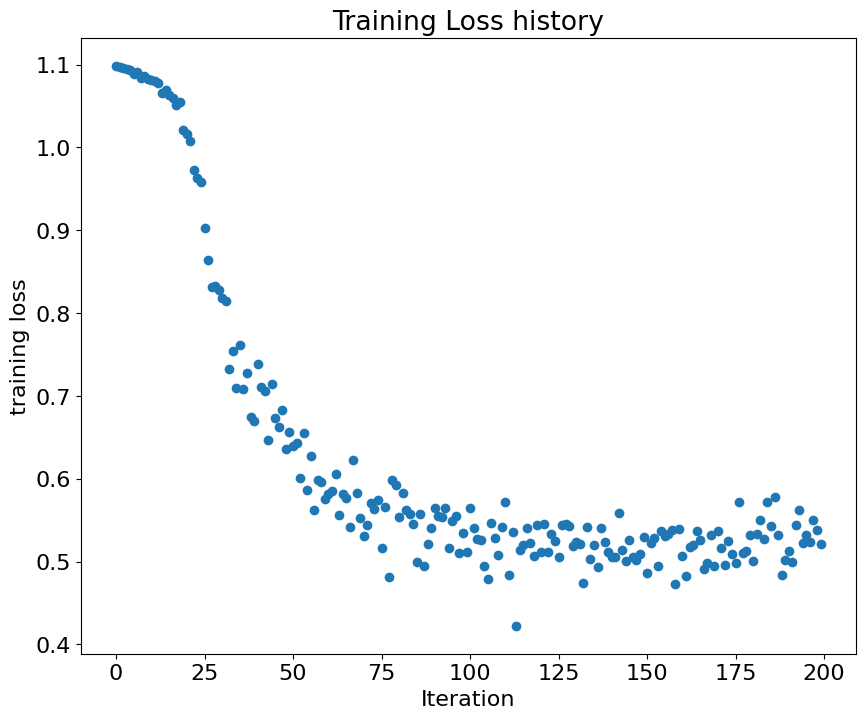

In [8]:
from two_layer_net import nn_forward_backward, nn_train, nn_predict,get_toy_data

toy_X, toy_y, params = get_toy_data()

stats = nn_train(params, nn_forward_backward, nn_predict, toy_X, toy_y, toy_X, toy_y,
                 learning_rate=1e-1, reg=1e-6,
                 num_iters=200, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'], 'o')
plt.xlabel('Iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

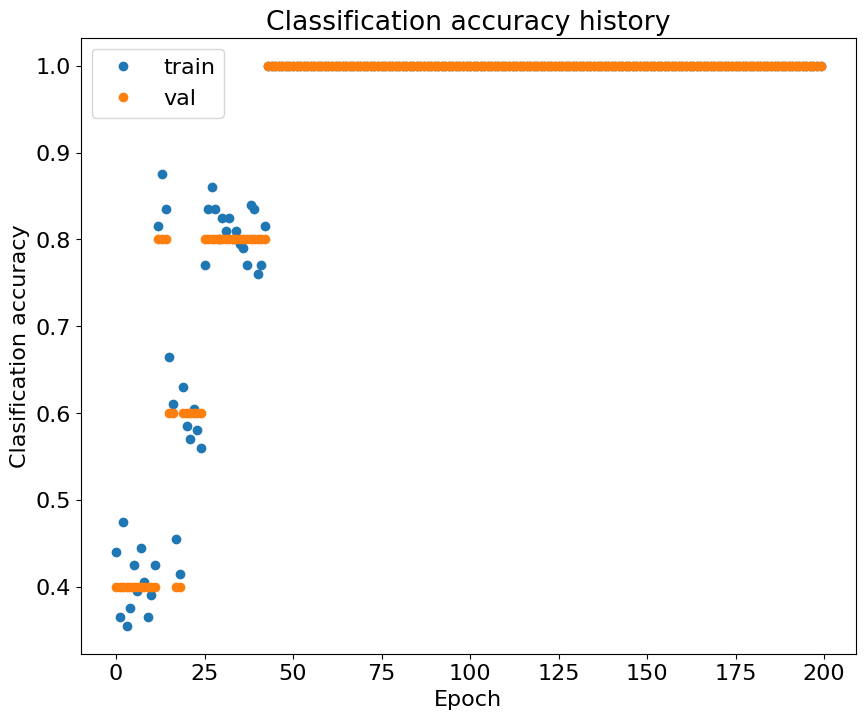

In [9]:
# Plot the loss function and train / validation accuracies
plt.plot(stats['train_acc_history'], 'o', label='train')
plt.plot(stats['val_acc_history'], 'o', label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

## Testing our NN on a real dataset: CIFAR-10

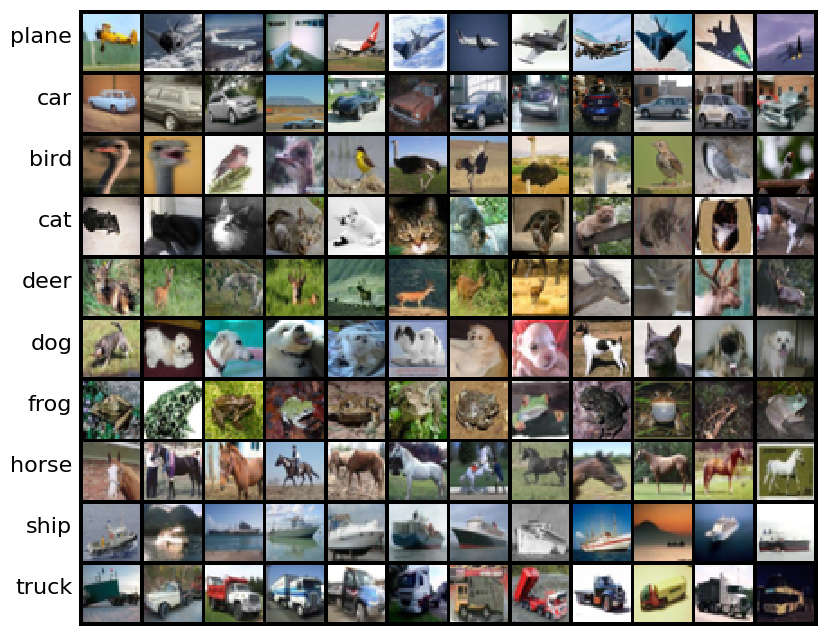

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [11]:
from two_layer_net import preprocess_cifar10

data_dict = preprocess_cifar10(dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

### Wrap all function into a Class

use the class `TwoLayerNet` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are PyTorch tensors.

### Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [12]:
from two_layer_net import TwoLayerNet

input_size = 3 * 32 * 32
hidden_size = 36
num_classes = 10

net = TwoLayerNet(input_size, hidden_size, num_classes, dtype=data_dict['X_train'].dtype, device=data_dict['X_train'].device)

# Train the network
stats = net.train(data_dict['X_train'], data_dict['y_train'],
                  data_dict['X_val'], data_dict['y_val'],
                  num_iters=500, batch_size=1000,
                  learning_rate=1e-2, learning_rate_decay=0.95,
                  reg=0.25, verbose=True)

# Predict on the validation set
y_val_pred = net.predict(data_dict['X_val'])
val_acc = 100.0 * (y_val_pred == data_dict['y_val']).double().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

iteration 0 / 500: loss 2.302863
iteration 100 / 500: loss 2.302695
iteration 200 / 500: loss 2.302669
iteration 300 / 500: loss 2.302551
iteration 400 / 500: loss 2.302571
Validation accuracy: 9.77%


### Debug the training

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

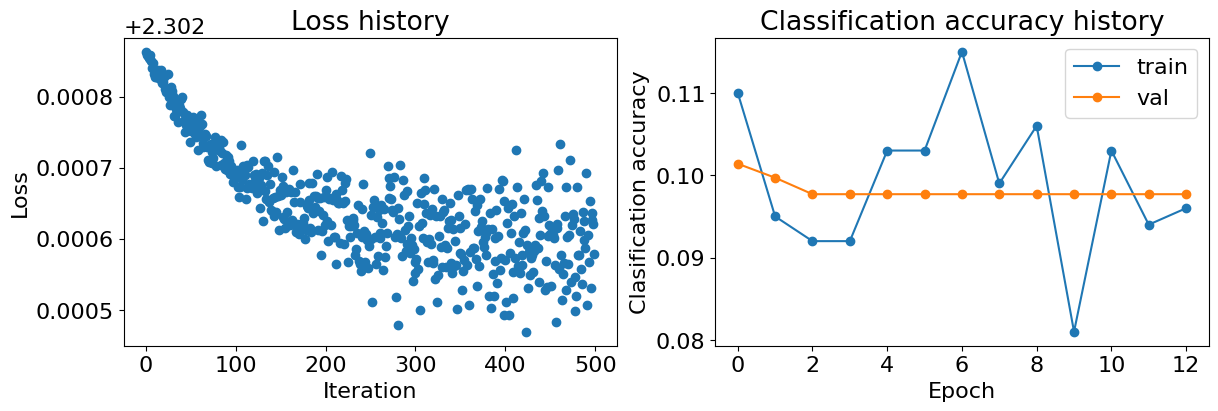

In [13]:
# Plot the loss function and train / validation accuracies
from two_layer_net import plot_stats

plot_stats(stats)

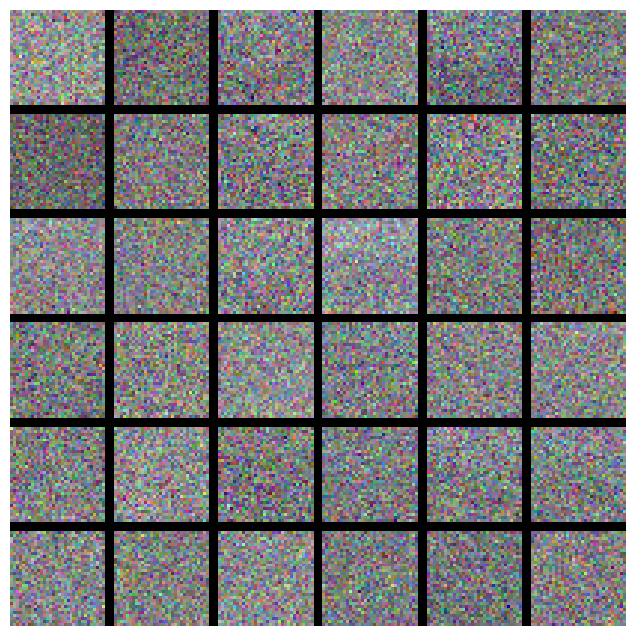

In [14]:
from two_layer_net import show_net_weights 

show_net_weights(net)

### What's wrong?
Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

#### Capacity?
Our initial model has very similar performance on the training and validation sets. This suggests that the model is underfitting, and that its performance might improve if we were to increase its capacity.

One way we can increase the capacity of a neural network model is to increase the size of its hidden layer. Here we investigate the effect of increasing the size of the hidden layer. The performance (as measured by validation-set accuracy) should increase as the size of the hidden layer increases; however it may show diminishing returns for larger layer sizes.

train with hidden size: 2
train with hidden size: 8
train with hidden size: 32
train with hidden size: 128


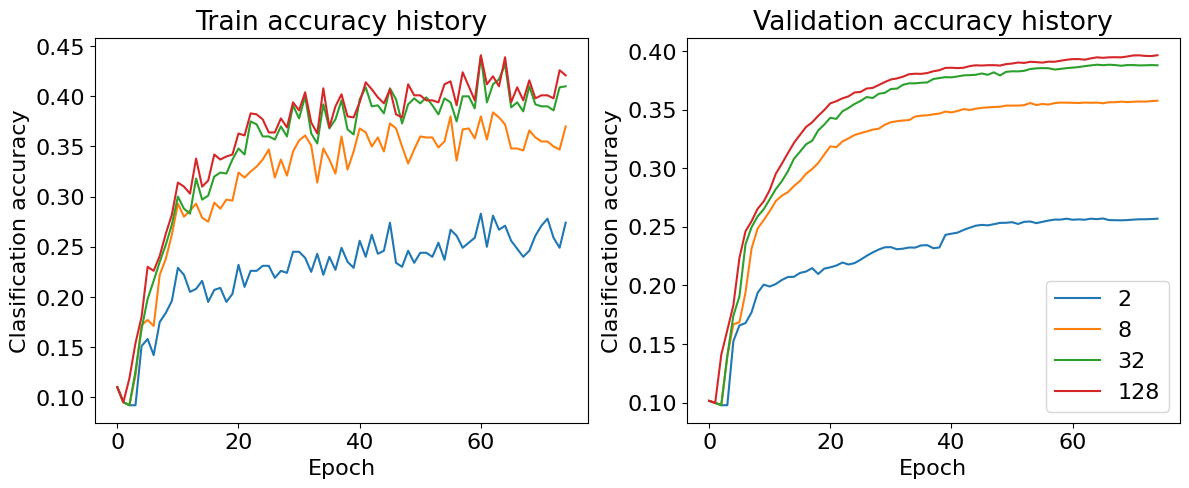

In [15]:
from two_layer_net import plot_acc_curves,TwoLayerNet

hidden_sizes = [2, 8, 32, 128] 
lr = 0.1
reg = 0.001

stat_dict = {}
for hs in hidden_sizes:
  print('train with hidden size: {}'.format(hs))
  
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[hs] = stats

plot_acc_curves(stat_dict)

#### Regularization?
Another possible explanation for the small gap we saw between the train and validation accuracies of our model is regularization. In particular, if the regularization coefficient were too high then the model may be unable to fit the training data.

We can investigate the phenomenon empirically by training a set of models with varying regularization strengths while fixing other hyperparameters.

You should see that setting the regularization strength too high will harm the validation-set performance of the model:

train with regularization: 0
train with regularization: 1e-05
train with regularization: 0.001
train with regularization: 0.1


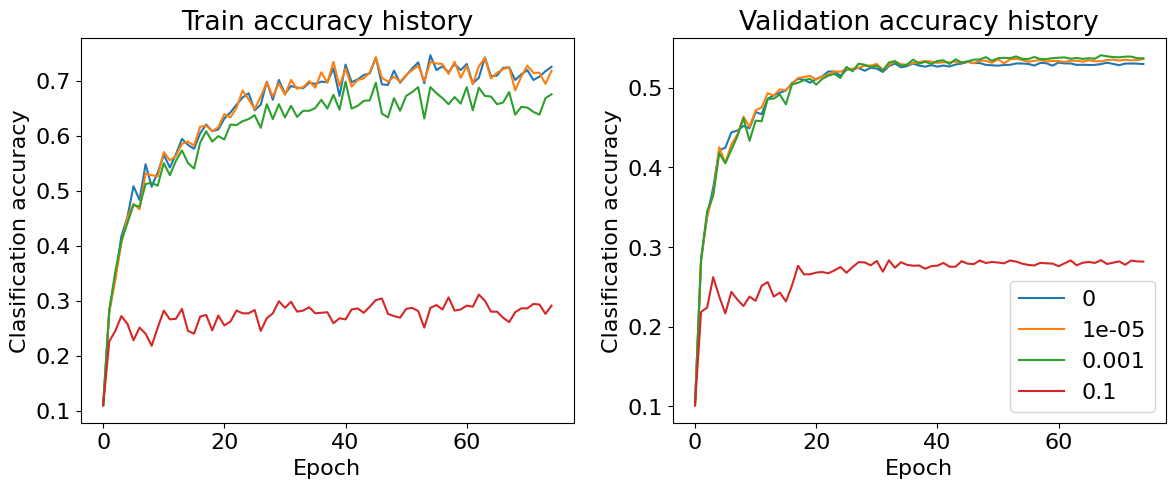

In [16]:
from two_layer_net import TwoLayerNet,plot_acc_curves

hs = 128
lr = 1.0
regs = [0, 1e-5, 1e-3, 1e-1]

stat_dict = {}
for reg in regs:
  print('train with regularization: {}'.format(reg))
  
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[reg] = stats

plot_acc_curves(stat_dict)

#### Learning Rate?
Last but not least, we also want to see the effect of learning rate with respect to the performance.

train with learning rate: 0.0001
train with learning rate: 0.01
train with learning rate: 1.0
train with learning rate: 100.0


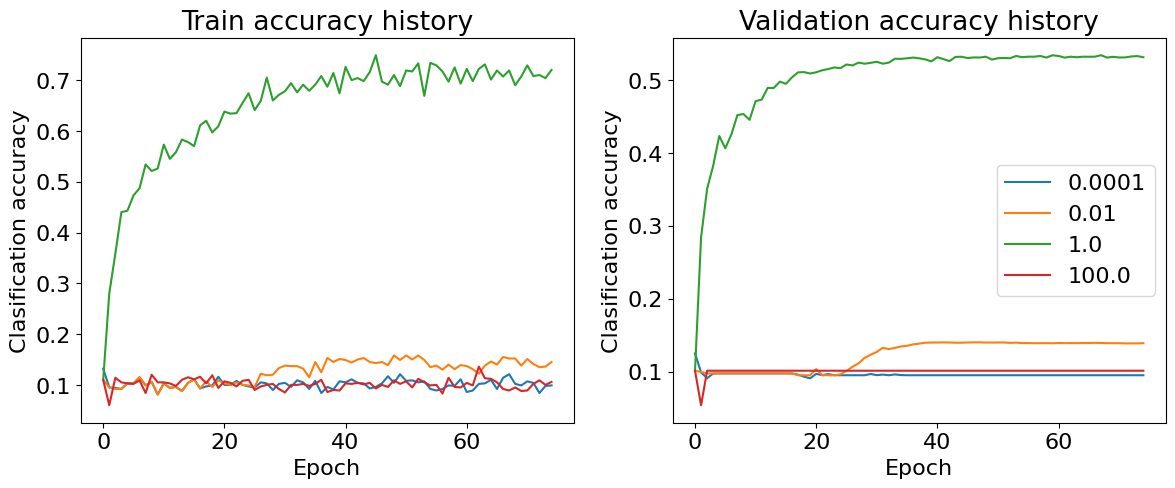

In [17]:
from two_layer_net import TwoLayerNet,plot_acc_curves

hs = 128
lrs = [1e-4, 1e-2, 1e0, 1e2]
reg = 1e-4

stat_dict = {}
for lr in lrs:
  print('train with learning rate: {}'.format(lr))
  
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[lr] = stats

plot_acc_curves(stat_dict)

### Tune the hyperparameters

Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks

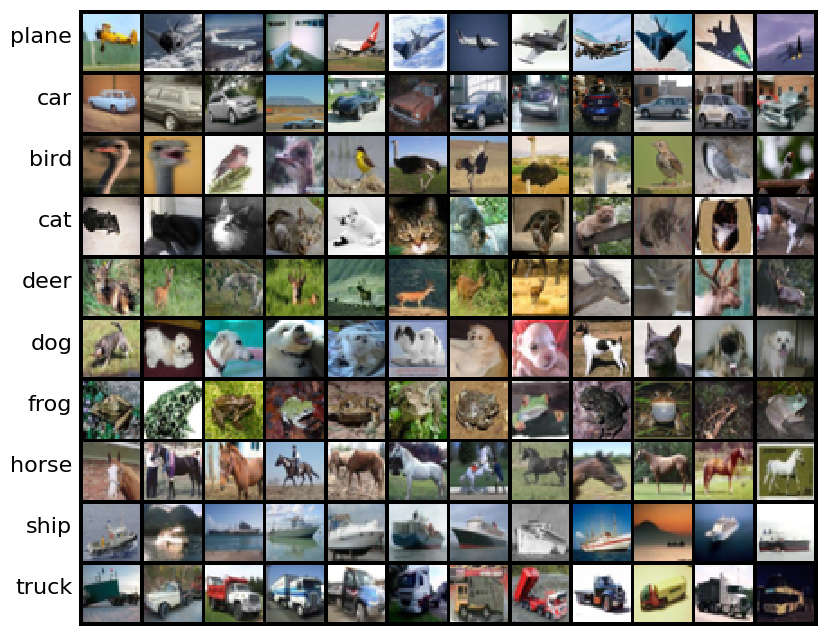

train with hidden_size: 32
train with learning_rate: 0.1
train with regularization: 1e-05
train with hidden_size: 64
train with learning_rate: 0.1
train with regularization: 1e-05
train with hidden_size: 128
train with learning_rate: 0.1
train with regularization: 1e-05
train with hidden_size: 32
train with learning_rate: 1
train with regularization: 1e-05
train with hidden_size: 64
train with learning_rate: 1
train with regularization: 1e-05
train with hidden_size: 128
train with learning_rate: 1
train with regularization: 1e-05
train with hidden_size: 32
train with learning_rate: 2
train with regularization: 1e-05
train with hidden_size: 64
train with learning_rate: 2
train with regularization: 1e-05
train with hidden_size: 128
train with learning_rate: 2
train with regularization: 1e-05
train with hidden_size: 32
train with learning_rate: 0.1
train with regularization: 0.0001
train with hidden_size: 64
train with learning_rate: 0.1
train with regularization: 0.0001
train with hidden

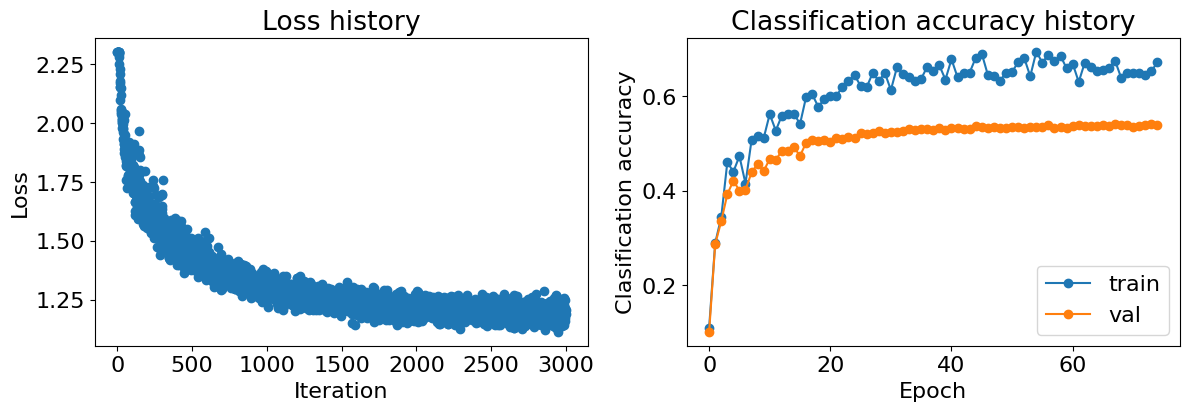

Saved in ../models\nn_best_model.pt


In [18]:
import os
from two_layer_net import TwoLayerNet, find_best_net, nn_get_search_params,preprocess_cifar10

data_dict = preprocess_cifar10(dtype=torch.float32)

best_net, best_stat, best_val_acc = find_best_net(data_dict, nn_get_search_params)
print(best_val_acc)

plot_stats(best_stat)

# save the best model
path = os.path.join('../models', 'nn_best_model.pt')
best_net.save(path)

In [19]:
# Check the validation-set accuracy of your best model
y_val_preds = best_net.predict(data_dict['X_val'])
val_acc = 100 * (y_val_preds == data_dict['y_val']).double().mean().item()
print('Best val-set accuracy: %.2f%%' % val_acc)

Best val-set accuracy: 53.94%


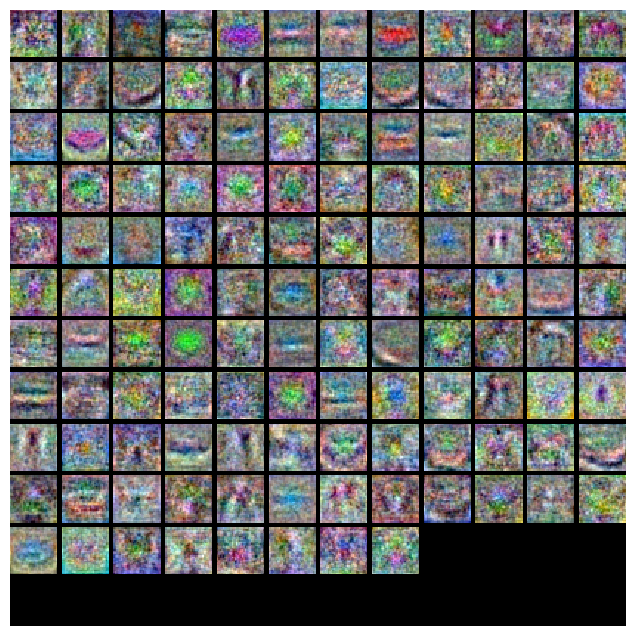

In [20]:
from two_layer_net import show_net_weights
# visualize the weights of the best network
show_net_weights(best_net)

### Run on the test set

In [21]:
y_test_preds = best_net.predict(data_dict['X_test'])
test_acc = 100 * (y_test_preds == data_dict['y_test']).double().mean().item()
print('Test accuracy: %.2f%%' % test_acc)

Test accuracy: 53.59%
